# Predicting Sunspots with Deep Neural Networks

In this project we will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. We will first build a deep neural network here composed of dense layers as a baseline and compare it with a more complex architecture.

## Imports

In [ ]:
pip install scikeras

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Conv1D, Bidirectional, LSTM,Dropout, Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Utilities

We create a fuction to plot the graphs.

In [ ]:
def plot_series(x,y,format='-', start=0, end=None, title=None, xlabel=None,
                ylabel=None, legend=None):
  """
  Visualize time series data

  Args:
    x (array of int) - contains values for the x-axis
    y (array of int or tuple of arrays) - contains the values for the y-axis
    format (string) - line style when plotting the graph
    start (int) - first time step to plot
    end (int) - last time step to plot
    title (string) - title of the plot
    xlabel (string) - label for the x-axis
    ylabel (string) - label for the y-axis
    legend (list of strings) - legend for the plot
  """

  # Setup dimensions of the figure
  plt.figure(figsize=(10,6))

  if type(y) is tuple:
    for y_num in y:
      plt.plot(x[start:end],y_num[start:end], format)
  else:
    plt.plot(x[start:end],y[start:end], format)

  # X-axis label
  plt.xlabel(xlabel)
  # Y-axis label
  plt.ylabel(ylabel)

  # Set the legend
  if legend:
    plt.legend(legend)

  # Overlay a grid on the graph
  plt.grid(True)

  # Plot the graph
  plt.show()

## Download the Dataset

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-04-05 20:57:12--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.207, 209.85.234.207, 142.251.180.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-04-05 20:57:13 (80.3 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



 Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [ ]:
data = pd.read_csv('./Sunspots.csv')
data = data.rename(columns={'Unnamed: 0':'Datetime'})
data.head()

,Datetime,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
# Verify the shape of the dataset
data.shape

(3235, 3)

In [ ]:
# check the data types
data.dtypes

Datetime                               int64
Date                                  object
Monthly Mean Total Sunspot Number    float64
dtype: object

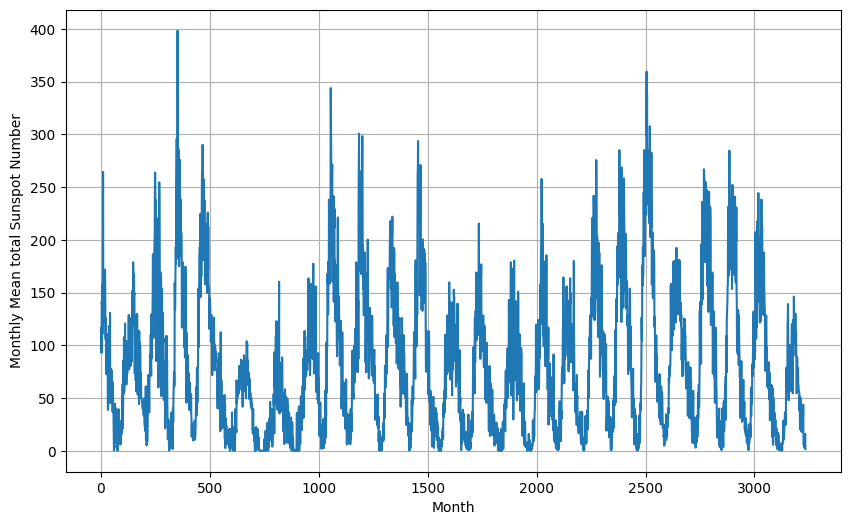

In [ ]:
time = data['Datetime']
series = data['Monthly Mean Total Sunspot Number']

plot_series(time, series, xlabel='Month', ylabel = 'Monthly Mean total Sunspot Number')

## Splot the Dataset

Next, we will split the dataset into training and validation sets. there are 3235 points in the dataset and we will use the first 3000 for training.

In [ ]:
# Defining the split time
SPLIT_TIME = 3000

# Get the train set
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

# Get the validation set
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

## Preparing Features and Labels

Now, we can prepare the dataset windows. The window size is set to 30 points (equal to 2.5 years).

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """

  Args:
    series (array of float) - contains the values of the time series
    window_size (int) - the number of time steps to include in the future
    batch_size (int) - the batch size
    shuffle_buffer (int) - buffer size to use for the shuffle method

  Returns:
    dataset (TF Dataset) - TF Dataset containing time windows
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with the specified size
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda w:w.batch(window_size+1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window:(window[:-1],window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [ ]:
# Declaring parameters

WINDOW_SIZE = 30
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

## Build the Base Model

In [ ]:
# Build the model
base_model = Sequential([
    Dense(30, input_shape=[WINDOW_SIZE], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

#Print the model summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
base_model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)

# Train the model

history = base_model.fit(train_set, epochs =100 , callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 1s 8ms/step - loss: 97.0895 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 5ms/step - loss: 94.3324 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 13ms/step - loss: 91.2985 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 2s 11ms/step - loss: 88.0222 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 10ms/step - loss: 84.4930 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 12ms/step - loss: 80.7462 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 2s 14ms/step - loss: 76.7683 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 10ms/step - loss: 72.5728 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 2s 20ms/step - loss: 68.2365 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 10ms/step - loss: 63.8302 - lr: 2.8184e-08
Epoch 11/10

(1e-08, 0.001, 0.0, 100.0)

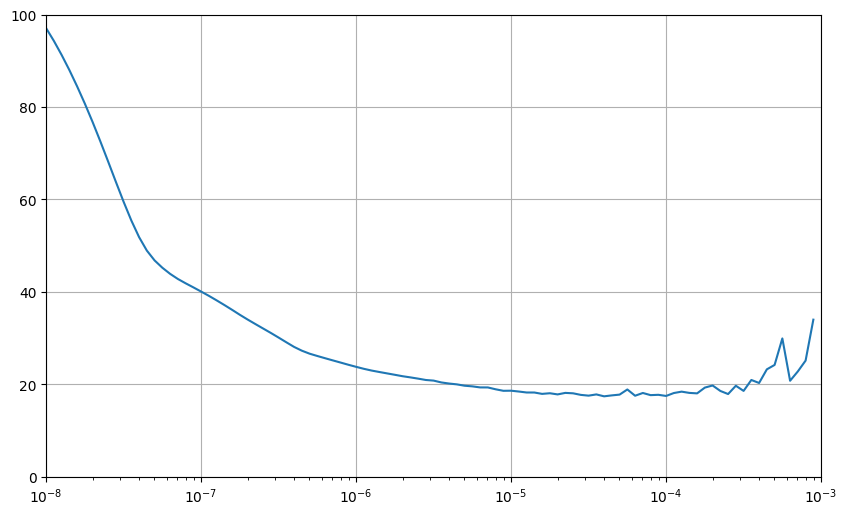

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10**(np.arange(100)/20))

#Set the figure size
plt.figure(figsize=(10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Set the plot bundaries
plt.axis([1e-8, 1e-3, 0, 100])

## train the Model
Once we have picked a learning rate, we can rebuild the model and start training.

In [ ]:
# Reset states generate by Keras
tf.keras.backend.clear_session()

# Build the Model
model = Sequential([
    Dense(30, input_shape=[WINDOW_SIZE], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [ ]:
# Set the learning rate
learning_rate = 5e-5

#Set the otpimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

#Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

# Train the model

history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 5ms/step - loss: 34.9883 - mae: 35.4815
Epoch 2/100
93/93 [==============================] - 1s 4ms/step - loss: 18.9807 - mae: 19.4724
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 18.4084 - mae: 18.9005
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 17.8109 - mae: 18.3018
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 18.2265 - mae: 18.7191
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 17.7985 - mae: 18.2891
Epoch 7/100
93/93 [==============================] - 1s 7ms/step - loss: 17.8154 - mae: 18.3080
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 17.8161 - mae: 18.3083
Epoch 9/100
93/93 [==============================] - 1s 5ms/step - loss: 17.6108 - mae: 18.1041
Epoch 10/100
93/93 [==============================] - 1s 4ms/step - loss: 17.3876 - mae: 17.8786
Epoch 11/100
93/93 [===================

## Model Prediction

Now see if the model generates good results.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
  """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda w:w.batch(window_size))

  #Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  # Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast

8/8 [==============================] - 0s 10ms/step


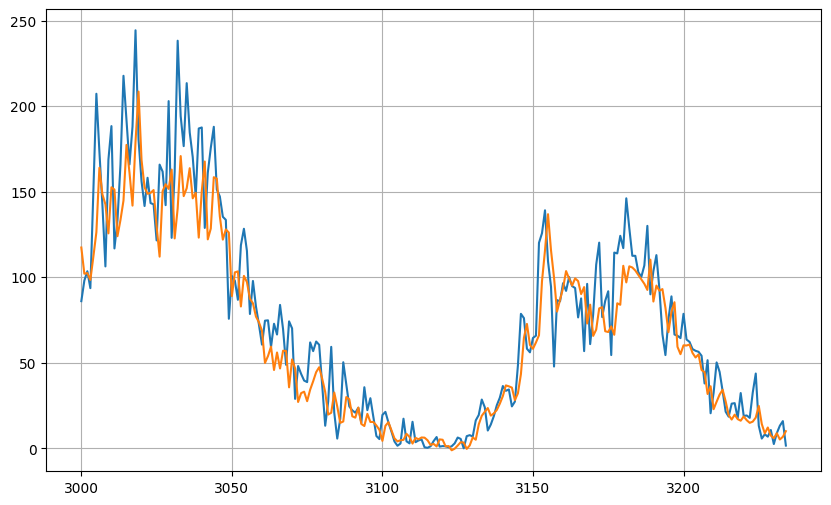

In [ ]:
# Reduce the original series
forecast_series = series[SPLIT_TIME-WINDOW_SIZE:-1]

# Use the helper fuction to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drio single dimension axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid,results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.564381


Now we will experiment with a complex architecture.



## Build the Complex Model

In [ ]:
# Build the model
complex_model = Sequential([
      Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='causal',
            input_shape = [WINDOW_SIZE,1]),
      LSTM(512, return_sequences=True),
      Dropout(0.5),
      LSTM(256),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dense(1),
      Lambda(lambda x:x*400)
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tuning the hyperparameters

We will pick the optimal hyperparameters such as: learning rate, lstm units, activation function and dropout rate.

In [ ]:
#Get initial weights
init_weights = complex_model.get_weights()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
complex_model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)

# Train the model

history_complex_model = complex_model.fit(train_set, epochs =100 , callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 66s 666ms/step - loss: 71.2286 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 62s 662ms/step - loss: 63.7517 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 62s 665ms/step - loss: 60.6369 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 63s 682ms/step - loss: 57.5019 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 68s 729ms/step - loss: 56.1047 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 75s 801ms/step - loss: 53.3777 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 74s 790ms/step - loss: 51.3969 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 84s 904ms/step - loss: 49.1577 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 77s 823ms/step - loss: 49.6397 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 65s 700ms/step - loss: 46.6051 - lr: 

The optimal learning rate is: 1.2589254117941676e-05


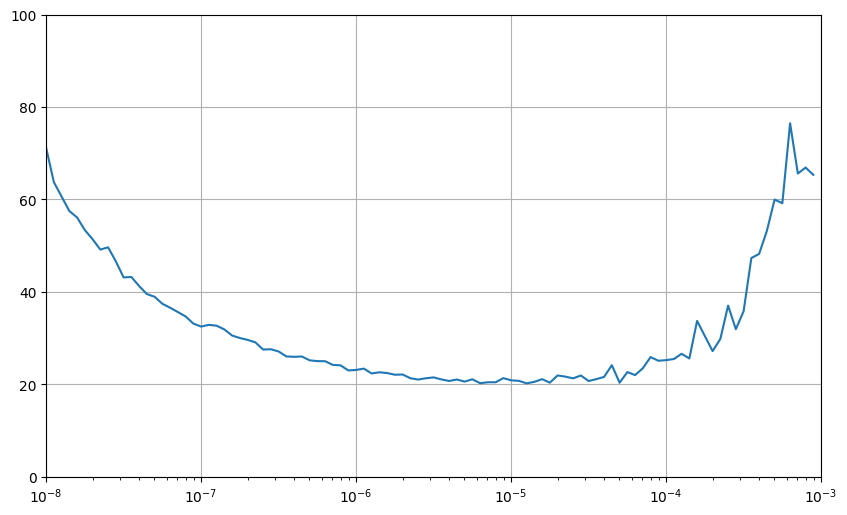

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10**(np.arange(100)/20))
loss = history_complex_model.history['loss']
#Set the figure size
plt.figure(figsize=(10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale
plt.semilogx(lrs, loss)

# Set the plot bundaries
plt.axis([1e-8, 1e-3, 0, 100])

#Getting the optimal learning rate

min_loss_index = np.argmin(loss)
optimal_lr = lrs[min_loss_index]
print(f'The optimal learning rate is: {optimal_lr}')

## train the model
Now we can proceed to reset and train the model.

In [ ]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Reset the weights
complex_model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = optimal_lr

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
complex_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [ ]:
# Train the model
history_complex_model = complex_model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 65s 648ms/step - loss: 33.7837 - mae: 34.2787
Epoch 2/100
93/93 [==============================] - 61s 654ms/step - loss: 25.2071 - mae: 25.7011
Epoch 3/100
93/93 [==============================] - 61s 650ms/step - loss: 23.1448 - mae: 23.6400
Epoch 4/100
93/93 [==============================] - 60s 648ms/step - loss: 22.2169 - mae: 22.7118
Epoch 5/100
93/93 [==============================] - 61s 655ms/step - loss: 22.1733 - mae: 22.6673
Epoch 6/100
93/93 [==============================] - 60s 648ms/step - loss: 21.7706 - mae: 22.2646
Epoch 7/100
93/93 [==============================] - 60s 638ms/step - loss: 21.6094 - mae: 22.1037
Epoch 8/100
93/93 [==============================] - 61s 652ms/step - loss: 21.0916 - mae: 21.5850
Epoch 9/100
93/93 [==============================] - 62s 663ms/step - loss: 20.7436 - mae: 21.2387
Epoch 10/100
93/93 [==============================] - 61s 659ms/step - loss: 20.8402 - mae: 21.3346
Epoch 11/

We can visualize the training and see if the loss and MAE are still trending down.


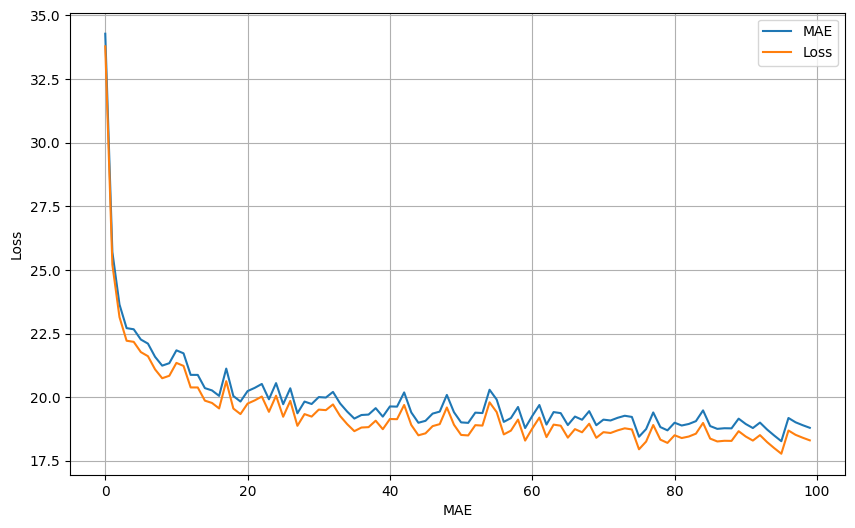

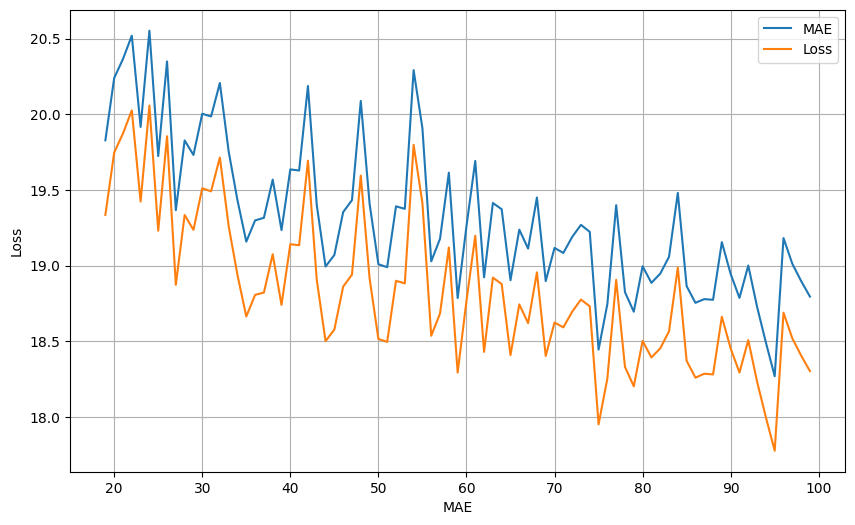

In [ ]:
# Get mae and loss from history log
mae=history_complex_model.history['mae']
loss=history_complex_model.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='MAE',
    ylabel='Loss', legend=['MAE', 'Loss'])

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(x=epochs_zoom, y=(mae_zoom, loss_zoom), title='MAE and Loss', xlabel='MAE',
    ylabel='Loss', legend=['MAE', 'Loss'])

## Model Prediction

Now we can get the predictions for the validation set time range and compute the metrics

8/8 [==============================] - 3s 141ms/step


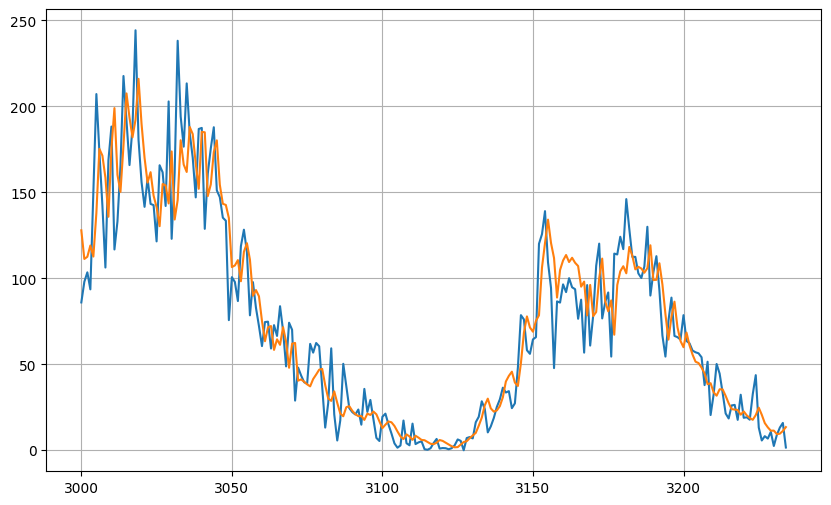

In [ ]:
# Reduce the original series
forecast_series = series[SPLIT_TIME-WINDOW_SIZE:-1]

# Use the helper function to generate predictions
forecast = model_forecast(complex_model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensions axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid,results))

In [ ]:
# Compute the MAE
tf.keras.metrics.MAE(x_valid, results).numpy()

15.002664